In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
#         self.relu = nn.ReLU()
        self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()
        self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*56*56, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
#         out = self.relu(out)
        out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
#         out = self.relu2(out)
        out = self.mish2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:53<00:00,  7.59it/s]


Train Loss: 1.302 | Accuracy: 37.565


100%|██████████| 102/102 [00:12<00:00,  8.20it/s]


Test Loss: 1.259 | Accuracy: 49.137

Epoch : 2


100%|██████████| 407/407 [00:47<00:00,  8.49it/s]


Train Loss: 1.134 | Accuracy: 50.131


100%|██████████| 102/102 [00:12<00:00,  8.06it/s]


Test Loss: 1.056 | Accuracy: 51.480

Epoch : 3


100%|██████████| 407/407 [00:48<00:00,  8.43it/s]


Train Loss: 1.012 | Accuracy: 53.038


100%|██████████| 102/102 [00:11<00:00,  9.02it/s]


Test Loss: 0.997 | Accuracy: 50.524

Epoch : 4


100%|██████████| 407/407 [00:49<00:00,  8.20it/s]


Train Loss: 0.978 | Accuracy: 54.529


100%|██████████| 102/102 [00:11<00:00,  8.92it/s]


Test Loss: 0.965 | Accuracy: 52.959

Epoch : 5


100%|██████████| 407/407 [00:49<00:00,  8.26it/s]


Train Loss: 0.931 | Accuracy: 57.621


100%|██████████| 102/102 [00:11<00:00,  9.08it/s]


Test Loss: 0.931 | Accuracy: 59.649

Epoch : 6


100%|██████████| 407/407 [00:49<00:00,  8.27it/s]


Train Loss: 0.880 | Accuracy: 61.804


100%|██████████| 102/102 [00:11<00:00,  8.87it/s]


Test Loss: 0.858 | Accuracy: 60.265

Epoch : 7


100%|██████████| 407/407 [00:47<00:00,  8.58it/s]


Train Loss: 0.810 | Accuracy: 66.287


100%|██████████| 102/102 [00:12<00:00,  8.39it/s]


Test Loss: 0.831 | Accuracy: 61.067

Epoch : 8


100%|██████████| 407/407 [00:47<00:00,  8.58it/s]


Train Loss: 0.744 | Accuracy: 69.540


100%|██████████| 102/102 [00:11<00:00,  8.99it/s]


Test Loss: 0.761 | Accuracy: 63.903

Epoch : 9


100%|██████████| 407/407 [00:49<00:00,  8.27it/s]


Train Loss: 0.697 | Accuracy: 71.670


100%|██████████| 102/102 [00:11<00:00,  8.86it/s]


Test Loss: 0.673 | Accuracy: 72.719

Epoch : 10


100%|██████████| 407/407 [00:48<00:00,  8.48it/s]


Train Loss: 0.668 | Accuracy: 72.278


100%|██████████| 102/102 [00:11<00:00,  8.98it/s]


Test Loss: 0.697 | Accuracy: 69.328

Epoch : 11


100%|██████████| 407/407 [00:49<00:00,  8.24it/s]


Train Loss: 0.656 | Accuracy: 72.962


100%|██████████| 102/102 [00:11<00:00,  9.06it/s]


Test Loss: 0.741 | Accuracy: 66.646

Epoch : 12


100%|██████████| 407/407 [00:47<00:00,  8.58it/s]


Train Loss: 0.636 | Accuracy: 73.847


100%|██████████| 102/102 [00:12<00:00,  8.38it/s]


Test Loss: 0.891 | Accuracy: 61.498

Epoch : 13


100%|██████████| 407/407 [00:47<00:00,  8.50it/s]


Train Loss: 0.617 | Accuracy: 75.169


100%|██████████| 102/102 [00:11<00:00,  8.82it/s]


Test Loss: 0.645 | Accuracy: 73.736

Epoch : 14


100%|██████████| 407/407 [00:47<00:00,  8.48it/s]


Train Loss: 0.603 | Accuracy: 75.661


100%|██████████| 102/102 [00:11<00:00,  9.03it/s]


Test Loss: 0.652 | Accuracy: 69.698

Epoch : 15


100%|██████████| 407/407 [00:48<00:00,  8.39it/s]


Train Loss: 0.595 | Accuracy: 76.192


100%|██████████| 102/102 [00:11<00:00,  9.01it/s]


Test Loss: 0.595 | Accuracy: 74.445

Epoch : 16


100%|██████████| 407/407 [00:49<00:00,  8.25it/s]


Train Loss: 0.582 | Accuracy: 76.922


100%|██████████| 102/102 [00:11<00:00,  8.51it/s]


Test Loss: 0.568 | Accuracy: 76.973

Epoch : 17


100%|██████████| 407/407 [00:48<00:00,  8.33it/s]


Train Loss: 0.575 | Accuracy: 76.838


100%|██████████| 102/102 [00:12<00:00,  8.04it/s]


Test Loss: 0.538 | Accuracy: 79.254

Epoch : 18


100%|██████████| 407/407 [00:47<00:00,  8.55it/s]


Train Loss: 0.565 | Accuracy: 77.468


100%|██████████| 102/102 [00:12<00:00,  8.37it/s]


Test Loss: 0.624 | Accuracy: 76.110

Epoch : 19


100%|██████████| 407/407 [00:47<00:00,  8.53it/s]


Train Loss: 0.556 | Accuracy: 78.045


100%|██████████| 102/102 [00:11<00:00,  8.96it/s]


Test Loss: 0.550 | Accuracy: 77.559

Epoch : 20


100%|██████████| 407/407 [00:49<00:00,  8.27it/s]


Train Loss: 0.549 | Accuracy: 78.307


100%|██████████| 102/102 [00:11<00:00,  8.66it/s]


Test Loss: 0.730 | Accuracy: 71.085

Epoch : 21


100%|██████████| 407/407 [00:48<00:00,  8.34it/s]


Train Loss: 0.545 | Accuracy: 78.399


100%|██████████| 102/102 [00:11<00:00,  8.93it/s]


Test Loss: 0.766 | Accuracy: 66.523

Epoch : 22


100%|██████████| 407/407 [00:48<00:00,  8.45it/s]


Train Loss: 0.535 | Accuracy: 78.422


100%|██████████| 102/102 [00:12<00:00,  8.25it/s]


Test Loss: 0.678 | Accuracy: 69.297

Epoch : 23


100%|██████████| 407/407 [00:47<00:00,  8.64it/s]


Train Loss: 0.521 | Accuracy: 79.414


100%|██████████| 102/102 [00:12<00:00,  8.45it/s]


Test Loss: 0.528 | Accuracy: 79.778

Epoch : 24


100%|██████████| 407/407 [00:47<00:00,  8.48it/s]


Train Loss: 0.525 | Accuracy: 79.245


100%|██████████| 102/102 [00:11<00:00,  9.07it/s]


Test Loss: 0.557 | Accuracy: 75.339

Epoch : 25


100%|██████████| 407/407 [00:48<00:00,  8.39it/s]


Train Loss: 0.514 | Accuracy: 79.983


100%|██████████| 102/102 [00:11<00:00,  9.17it/s]


Test Loss: 0.492 | Accuracy: 82.337

Epoch : 26


100%|██████████| 407/407 [00:48<00:00,  8.42it/s]


Train Loss: 0.505 | Accuracy: 80.306


100%|██████████| 102/102 [00:11<00:00,  9.17it/s]


Test Loss: 0.471 | Accuracy: 82.645

Epoch : 27


100%|██████████| 407/407 [00:47<00:00,  8.59it/s]


Train Loss: 0.494 | Accuracy: 80.583


100%|██████████| 102/102 [00:12<00:00,  8.38it/s]


Test Loss: 0.468 | Accuracy: 81.689

Epoch : 28


100%|██████████| 407/407 [00:47<00:00,  8.56it/s]


Train Loss: 0.497 | Accuracy: 80.537


100%|██████████| 102/102 [00:11<00:00,  9.18it/s]


Test Loss: 0.481 | Accuracy: 81.350

Epoch : 29


100%|██████████| 407/407 [00:48<00:00,  8.34it/s]


Train Loss: 0.494 | Accuracy: 81.114


100%|██████████| 102/102 [00:11<00:00,  9.00it/s]


Test Loss: 0.569 | Accuracy: 77.281

Epoch : 30


100%|██████████| 407/407 [00:47<00:00,  8.63it/s]


Train Loss: 0.481 | Accuracy: 81.075


100%|██████████| 102/102 [00:12<00:00,  8.47it/s]


Test Loss: 0.502 | Accuracy: 78.237

Epoch : 31


100%|██████████| 407/407 [00:48<00:00,  8.36it/s]


Train Loss: 0.483 | Accuracy: 81.052


100%|██████████| 102/102 [00:12<00:00,  8.05it/s]


Test Loss: 0.552 | Accuracy: 75.401

Epoch : 32


100%|██████████| 407/407 [00:48<00:00,  8.35it/s]


Train Loss: 0.472 | Accuracy: 81.798


100%|██████████| 102/102 [00:11<00:00,  8.96it/s]


Test Loss: 0.604 | Accuracy: 76.850

Epoch : 33


100%|██████████| 407/407 [00:48<00:00,  8.35it/s]


Train Loss: 0.466 | Accuracy: 81.560


100%|██████████| 102/102 [00:11<00:00,  9.26it/s]


Test Loss: 0.529 | Accuracy: 76.141

Epoch : 34


100%|██████████| 407/407 [00:48<00:00,  8.43it/s]


Train Loss: 0.470 | Accuracy: 81.806


100%|██████████| 102/102 [00:11<00:00,  9.23it/s]


Test Loss: 0.466 | Accuracy: 80.734

Epoch : 35


100%|██████████| 407/407 [00:47<00:00,  8.49it/s]


Train Loss: 0.460 | Accuracy: 81.959


100%|██████████| 102/102 [00:11<00:00,  9.11it/s]


Test Loss: 0.476 | Accuracy: 80.179

Epoch : 36


100%|██████████| 407/407 [00:47<00:00,  8.50it/s]


Train Loss: 0.446 | Accuracy: 82.444


100%|██████████| 102/102 [00:12<00:00,  8.32it/s]


Test Loss: 0.451 | Accuracy: 83.323

Epoch : 37


100%|██████████| 407/407 [00:48<00:00,  8.40it/s]


Train Loss: 0.452 | Accuracy: 82.728


100%|██████████| 102/102 [00:12<00:00,  8.34it/s]


Test Loss: 0.454 | Accuracy: 83.385

Epoch : 38


100%|██████████| 407/407 [00:48<00:00,  8.32it/s]


Train Loss: 0.445 | Accuracy: 82.982


100%|██████████| 102/102 [00:11<00:00,  9.17it/s]


Test Loss: 0.440 | Accuracy: 83.847

Epoch : 39


100%|██████████| 407/407 [00:48<00:00,  8.47it/s]


Train Loss: 0.438 | Accuracy: 82.828


100%|██████████| 102/102 [00:11<00:00,  9.19it/s]


Test Loss: 0.412 | Accuracy: 84.741

Epoch : 40


100%|██████████| 407/407 [00:48<00:00,  8.46it/s]


Train Loss: 0.434 | Accuracy: 82.851


100%|██████████| 102/102 [00:11<00:00,  9.21it/s]


Test Loss: 0.478 | Accuracy: 81.473

Epoch : 41


100%|██████████| 407/407 [00:47<00:00,  8.64it/s]


Train Loss: 0.439 | Accuracy: 82.982


100%|██████████| 102/102 [00:11<00:00,  8.55it/s]


Test Loss: 0.441 | Accuracy: 83.231

Epoch : 42


100%|██████████| 407/407 [00:48<00:00,  8.43it/s]


Train Loss: 0.427 | Accuracy: 83.651


100%|██████████| 102/102 [00:12<00:00,  8.30it/s]


Test Loss: 0.438 | Accuracy: 83.015

Epoch : 43


100%|██████████| 407/407 [00:48<00:00,  8.32it/s]


Train Loss: 0.427 | Accuracy: 83.451


100%|██████████| 102/102 [00:11<00:00,  8.94it/s]


Test Loss: 0.543 | Accuracy: 77.959

Epoch : 44


100%|██████████| 407/407 [00:48<00:00,  8.47it/s]


Train Loss: 0.425 | Accuracy: 83.051


100%|██████████| 102/102 [00:11<00:00,  8.94it/s]


Test Loss: 0.460 | Accuracy: 83.076

Epoch : 45


100%|██████████| 407/407 [00:48<00:00,  8.37it/s]


Train Loss: 0.432 | Accuracy: 83.590


100%|██████████| 102/102 [00:11<00:00,  8.92it/s]


Test Loss: 0.429 | Accuracy: 84.340

Epoch : 46


100%|██████████| 407/407 [00:46<00:00,  8.70it/s]


Train Loss: 0.424 | Accuracy: 83.567


100%|██████████| 102/102 [00:11<00:00,  8.53it/s]


Test Loss: 0.395 | Accuracy: 85.604

Epoch : 47


100%|██████████| 407/407 [00:47<00:00,  8.50it/s]


Train Loss: 0.426 | Accuracy: 83.128


100%|██████████| 102/102 [00:12<00:00,  8.31it/s]


Test Loss: 0.496 | Accuracy: 81.443

Epoch : 48


100%|██████████| 407/407 [00:48<00:00,  8.38it/s]


Train Loss: 0.415 | Accuracy: 83.867


100%|██████████| 102/102 [00:11<00:00,  8.96it/s]


Test Loss: 0.438 | Accuracy: 82.984

Epoch : 49


100%|██████████| 407/407 [00:49<00:00,  8.22it/s]


Train Loss: 0.415 | Accuracy: 84.005


100%|██████████| 102/102 [00:11<00:00,  9.09it/s]

Test Loss: 0.495 | Accuracy: 80.148


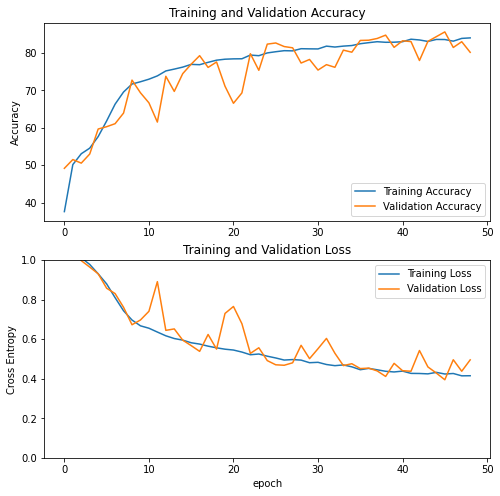

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
!pip install playsound

from playsound import playsound
  
# for playing note.wav file
playsound('/path/note.wav')
print('playing sound using  playsound')

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=06e104f73c8ba5c7cef4079b50f745d51a7288b23f0ce8dd04eccd87c3ebc00d
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


PlaysoundException: Cannot find a sound with filename: /path/note.wav

In [ ]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])